In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [2]:
TARGETS = ['AB42_AB40Positivity', 'tTau_AB42Positivity', 'pTau_Positivity']

MOCA = ['MOCATOTS']
CRAFT = ['CRAFTVRS', 'CRAFTURS', 'CRAFTDVR', 'CRAFTDRE']
FLUENCY_FL = ['UDSVERFC', 'UDSVERLC']
FLUENCY_AV = ['ANIMALS', 'VEG']
TRAIL = ['TRAILA', 'TRAILB']
SPAN_F = ['DIGFORCT', 'DIGFORSL']
SPAN_B = ['DIGBACCT', 'DIGBACLS']

TASKS =  [
    
    (MOCA, 'T-MoCa'), (CRAFT, 'Craft Story'), (TRAIL, 'Oral Trail Making'), 
    (FLUENCY_FL + FLUENCY_AV, 'Verbal Fluency'), 
    (FLUENCY_FL, 'Verbal Fluency\n(F & L)'), (FLUENCY_AV, 'Verbal Fluency\n(Animals & Vegetables)'),
    (SPAN_B + SPAN_F, 'Number Span'),
    (SPAN_F, 'Number Span\n(Forward)'), (SPAN_B, 'Number Span\n(Backward)'),
    (MOCA+CRAFT+FLUENCY_AV+FLUENCY_FL+TRAIL+SPAN_B+SPAN_F, 'All')
]

In [3]:
def load_raw_data(feats: list[str], target: str):
    # Load the entire csv file
    data = pd.read_csv('data/labels.csv')[['id'] + feats + [target]]
    data[target] = data[target].map(lambda x: np.nan if x==' ' else x)

    data = data.dropna()
    data[target] = data[target].astype(int)

    # Extract only the ground truths
    labels = pd.DataFrame(data[target], columns=[target])
    data = data.drop(target, axis=1)

    data = data.set_index('id')

    return data.reset_index(), labels.reset_index()[target]

In [9]:
def analyze(feats, task, runs=10):
    bar = tqdm(range(runs))
    bar.set_description(task.replace('\n', ' ') + ' '*(37-len(task)))
    
    means, stdevs = {}, {}
    partial = {target: [] for target in TARGETS}
    for _ in bar:
        for target in TARGETS:
            loo = LeaveOneOut()
            ys_true, ys_pred = [], []
            
            X, y = load_raw_data(feats, target)
            for train_index, test_index in loo.split(X):
                model = RandomForestClassifier(n_estimators = 100)
                model.fit(X.iloc[train_index], y.iloc[train_index])

                ys_pred.append(model.predict(X.iloc[test_index])[0])
                ys_true.append(y.iloc[test_index].values[0])

            partial[target].append(
                (accuracy_score(ys_pred, ys_true),
                 f1_score(ys_pred, ys_true),
                 roc_auc_score(ys_pred, ys_true))
            )
    for target in TARGETS:
        accs, f1s, rocs = zip(*partial[target])
        means[target] = {
            'Accuracy': np.mean(accs),
            'F1 Score': np.mean(f1s),
            'ROC-AUC':  np.mean(rocs)
        }
        stdevs[target] = {
            'Accuracy': np.std(accs),
            'F1 Score': np.std(f1s),
            'ROC-AUC':  np.std(rocs)
        }
    return means, stdevs
         

In [37]:
def plot(means: dict[str, dict[str, dict[str, float]]], stdevs: dict[str, dict[str, dict[str, float]]]):
    for metric in ['ROC-AUC', 'F1 Score', 'Accuracy']:
        to_visualize = {'index': []}
        to_print = {'index': []}
        for cog_task in means.keys():
            to_visualize['index'].append(cog_task)
            to_print['index'].append(cog_task.replace('\n', ' '))
            by_target = means[cog_task]
            for target in by_target.keys():
                if target not in to_visualize:
                    to_visualize[target] = []
                    to_print[target] = []
                to_visualize[target].append(means[cog_task][target][metric])
                to_print[target].append(f'{means[cog_task][target][metric]:0.4f} +- {stdevs[cog_task][target][metric]:0.4f}')

        df = pd.DataFrame(to_visualize)
        fig, ax = plt.subplots(1, 3, figsize=(12,4))
        fig.tight_layout(w_pad=10, h_pad=4)
        plt.suptitle(metric, y=1.04, fontsize=16)
        for idx, target in enumerate(TARGETS):
            b = sns.barplot(df, x=target, y='index', orient='h', ax=ax[idx])
            b.set(xlabel=target, ylabel=None)
        plt.show()
        display(pd.DataFrame(to_print))
        print('*'*100)
     

In [12]:
data_mean, data_stdevs = {}, {}
for feats, task in TASKS:
    data_mean[task], data_stdevs[task] = analyze(feats, task)

All                                  : 100%|██████████| 10/10 [03:57<00:00, 23.73s/it]


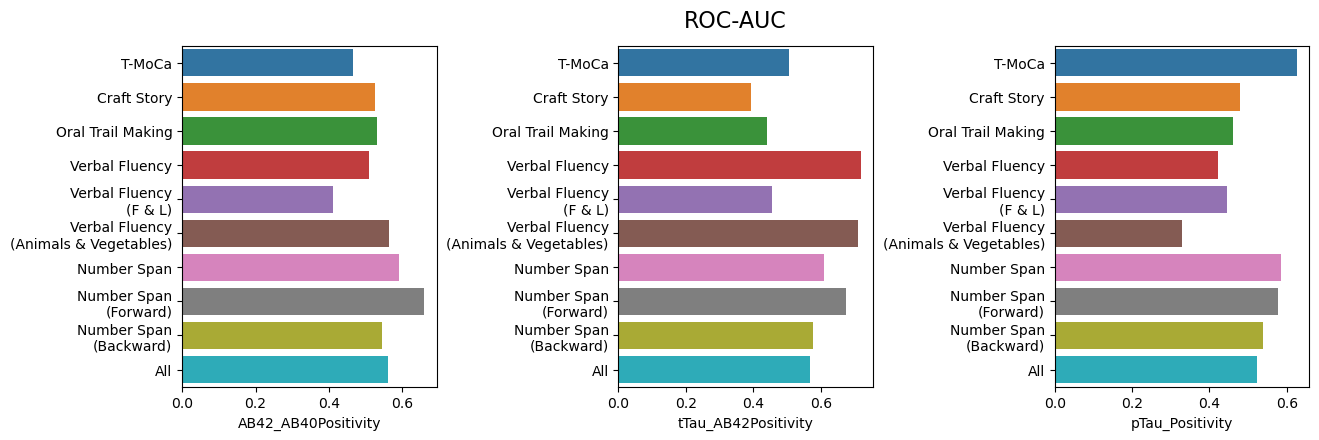

,index,AB42_AB40Positivity,tTau_AB42Positivity,pTau_Positivity
0,T-MoCa,0.4652 +- 0.0093,0.5056 +- 0.0107,0.6264 +- 0.0168
1,Craft Story,0.5246 +- 0.0225,0.3923 +- 0.0233,0.4797 +- 0.0370
2,Oral Trail Making,0.5295 +- 0.0173,0.4412 +- 0.0214,0.4600 +- 0.0164
3,Verbal Fluency,0.5078 +- 0.0252,0.7184 +- 0.0294,0.4209 +- 0.0350
4,Verbal Fluency (F & L),0.4099 +- 0.0361,0.4540 +- 0.0368,0.4456 +- 0.0252
5,Verbal Fluency (Animals & Vegetables),0.5647 +- 0.0195,0.7113 +- 0.0224,0.3290 +- 0.0211
6,Number Span,0.5898 +- 0.0199,0.6096 +- 0.0621,0.5851 +- 0.0333
7,Number Span (Forward),0.6600 +- 0.0211,0.6739 +- 0.0217,0.5783 +- 0.0205
8,Number Span (Backward),0.5437 +- 0.0246,0.5759 +- 0.0213,0.5380 +- 0.0158
9,All,0.5595 +- 0.0364,0.5676 +- 0.0900,0.5220 +- 0.0489


****************************************************************************************************


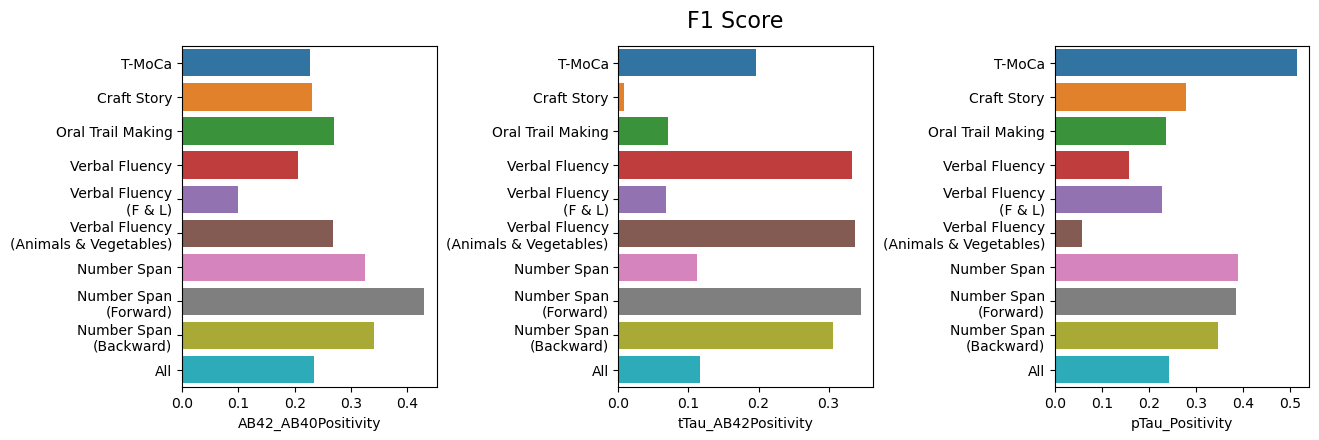

,index,AB42_AB40Positivity,tTau_AB42Positivity,pTau_Positivity
0,T-MoCa,0.2264 +- 0.0054,0.1963 +- 0.0071,0.5151 +- 0.0249
1,Craft Story,0.2310 +- 0.0290,0.0083 +- 0.0250,0.2784 +- 0.0487
2,Oral Trail Making,0.2696 +- 0.0185,0.0708 +- 0.0237,0.2365 +- 0.0222
3,Verbal Fluency,0.2056 +- 0.0364,0.3332 +- 0.0221,0.1583 +- 0.0412
4,Verbal Fluency (F & L),0.0990 +- 0.0454,0.0683 +- 0.0344,0.2271 +- 0.0296
5,Verbal Fluency (Animals & Vegetables),0.2684 +- 0.0273,0.3377 +- 0.0066,0.0580 +- 0.0280
6,Number Span,0.3238 +- 0.0292,0.1116 +- 0.0296,0.3887 +- 0.0420
7,Number Span (Forward),0.4302 +- 0.0329,0.3459 +- 0.0321,0.3853 +- 0.0274
8,Number Span (Backward),0.3408 +- 0.0390,0.3067 +- 0.0386,0.3476 +- 0.0239
9,All,0.2350 +- 0.0458,0.1167 +- 0.0580,0.2421 +- 0.0582


****************************************************************************************************


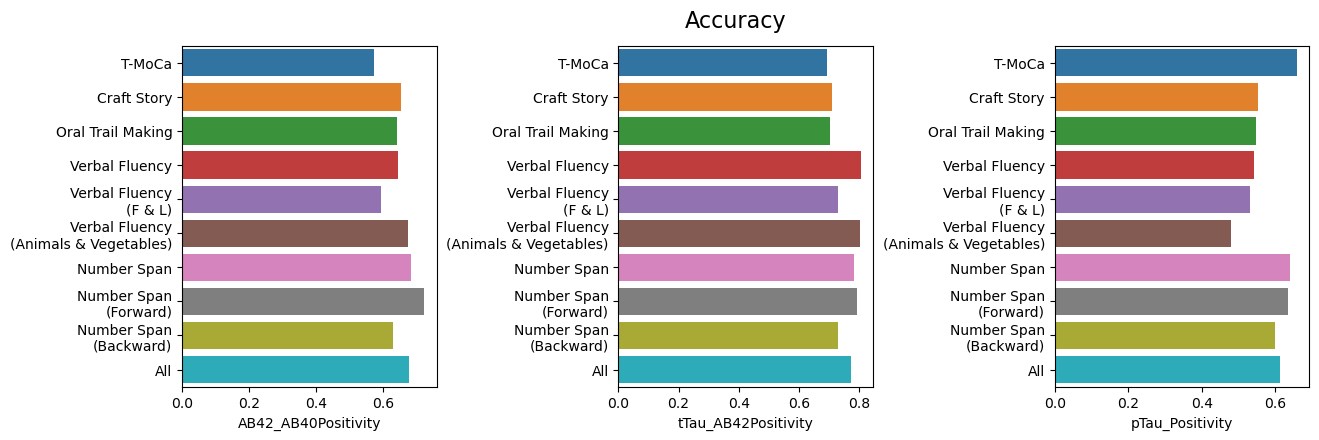

,index,AB42_AB40Positivity,tTau_AB42Positivity,pTau_Positivity
0,T-MoCa,0.5725 +- 0.0135,0.6925 +- 0.0139,0.6595 +- 0.0146
1,Craft Story,0.6512 +- 0.0131,0.7100 +- 0.0192,0.5527 +- 0.0305
2,Oral Trail Making,0.6413 +- 0.0148,0.7038 +- 0.0137,0.5473 +- 0.0163
3,Verbal Fluency,0.6450 +- 0.0150,0.8050 +- 0.0083,0.5419 +- 0.0252
4,Verbal Fluency (F & L),0.5938 +- 0.0188,0.7300 +- 0.0139,0.5311 +- 0.0234
5,Verbal Fluency (Animals & Vegetables),0.6738 +- 0.0104,0.8037 +- 0.0057,0.4784 +- 0.0150
6,Number Span,0.6825 +- 0.0115,0.7812 +- 0.0101,0.6392 +- 0.0250
7,Number Span (Forward),0.7225 +- 0.0122,0.7925 +- 0.0083,0.6338 +- 0.0153
8,Number Span (Backward),0.6288 +- 0.0168,0.7300 +- 0.0115,0.6000 +- 0.0138
9,All,0.6762 +- 0.0172,0.7737 +- 0.0142,0.6135 +- 0.0251


****************************************************************************************************


In [38]:
plot(data_mean, data_stdevs)